In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

In [2]:
from datetime import time, timedelta, datetime
import typing as T
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
import math
from functools import partial

plt.rcParams['figure.figsize'] = [10, 5]

config_dirs = open("prefixo_dados.txt").readlines() 
DIR_PREFIXO = Path(config_dirs[0].strip())


DIRETORIO_PRINCIPAL =  DIR_PREFIXO / "Projeto_PA" / "Projeto_PA_validado"
DIRETORIO_DATASET = DIR_PREFIXO / "Projeto_PA"


DIR_PADROES_DOENCA = DIRETORIO_PRINCIPAL / "padrao_doenca"
DIR_QUANTITATIVOS = DIRETORIO_PRINCIPAL / "quantitativos"
DIR_ESTATISTICAS = DIRETORIO_PRINCIPAL / "estatisticas"
DIR_GRAFICOS = DIRETORIO_PRINCIPAL / "graficos_diagnosticados"
DIR_GRAFICOS_SALVOS = DIR_PADROES_DOENCA / "graficos_salvos"
DIR_GRAFICOS_MEDIAS = DIRETORIO_PRINCIPAL / "grafico_medias_todas_PAs"


# PERÍODOS 
#      Matutino 6h-8h59       Dataset 6h-8h45
#      Diurno 9h-20h59                9h-20h45
#      Vespertino 21h-22h59           21h-22h45
#      Noturno 23h-05h59              23h-5h30

matutino = (time(6,0), time(9,0))
diurno = (time(9,0), time(21,0))
vespertino = (time(21,0), time(1,0))
noturno = (time(1,0), time(6,0))

# Valores de Referência Normal das Sistólicas e Diastólicas
max_sist = 140
min_sist = 100
max_diast = 90
min_diast = 60

# IDADE >=60 then é idoso
limite_idoso = 60

################### mapas = pd.read_csv("D:\Projeto_PA\pacientes_com_id.csv", sep=";", encoding="latin1")
################### plt.savefig ("C:\Documentos\Projeto_PA\Projeto_PA_validado\grafico_medias_todas_PAs\media_todas_PAs.svg")

#  Dataset COM Whitecoat
mapas = pd.read_csv(DIRETORIO_DATASET / "dataset_modificado" / "pacientes_apos_regras_com_whitecoat.csv", 
                    sep=";", encoding="Latin1")

#  Dataset SEM Whitecoat
mapas_sem_Whitecoat = pd.read_csv(DIRETORIO_DATASET / "dataset_modificado"  / "pacientes_aceitos.csv", 
                                  sep=";", encoding="Latin1")

identificacao = mapas.loc[:, 'numero_identificacao']

# Identificando o intervalo de todas as PASs e todas as PADs
sist = mapas.loc[:,'sist 9:00':'sist 8:45']
diast = mapas.loc[:,'diast 9:00':'diast 8:45']

# Dataframe das Sistólicas e Diastólicas em cada turno 
sist_matutino = sist.loc[:,'sist 6:00':'sist 8:45']
sist_diurno = sist.loc[:,'sist 9:00':'sist 20:45']
sist_vespertino = sist.loc[:,'sist 21:00':'sist 22:45']
sist_noturno = sist.loc[:,'sist 23:00':'sist 5:30']
diast_matutino = diast.loc[:,'diast 6:00':'diast 8:45']
diast_diurno = diast.loc[:,'diast 9:00':'diast 20:45']
diast_vespertino = diast.loc[:,'diast 21:00':'diast 22:45']
diast_noturno = diast.loc[:,'diast 23:00':'diast 5:30']

# Concatena os turnos de Daytime, sendo que Sistólica e Diastólica no turno da noite já está identificada acima
sist_dia = pd.concat([sist_matutino, sist_diurno, sist_vespertino], axis=1)
diast_dia = pd.concat([diast_matutino, diast_diurno, diast_vespertino], axis=1)

# Divisão por Períodos de Tempo
mapa_matutino = pd.concat([identificacao, sist_matutino, diast_matutino], axis=1)
mapa_diurno = pd.concat([identificacao, sist_diurno, diast_diurno], axis=1)
mapa_vespertino = pd.concat([identificacao, sist_vespertino, diast_vespertino], axis=1)
mapa_noturno = pd.concat([identificacao, sist_noturno, diast_noturno], axis=1)
mapa_dia = pd.concat([identificacao, sist_dia, diast_dia], axis=1)

# Verificação de que a montagem dos DF com sist e diast usando os dataframes parciais anteriores
# é igual a montagem usando as colunas explícitas novamente ;
# (lembrando que a expressao "NaN == NaN" sempre retorna False)
# mapa_matutino=pd.concat([mapas.loc[:,'numero_identificacao'],mapas.loc[:,'sist 6:00':'sist 8:45'],mapas.loc[:,'diast 6:00':'diast 8:45']],axis=1)
# print(mapa_matutino_2 == mapa_matutino, mapa_matutino_2, mapa_matutino, sep="\n******\n")
# print(mapa_noturno.head())


# Informando os horários em todos os gráficos no eixo X

time_labels = [titulo.split(" ")[-1] for titulo in diast.columns]
print(time_labels)

['9:00', '9:15', '9:30', '9:45', '10:00', '10:15', '10:30', '10:45', '11:00', '11:15', '11:30', '11:45', '12:00', '12:15', '12:30', '12:45', '13:00', '13:15', '13:30', '13:45', '14:00', '14:15', '14:30', '14:45', '15:00', '15:15', '15:30', '15:45', '16:00', '16:15', '16:30', '16:45', '17:00', '17:15', '17:30', '17:45', '18:00', '18:15', '18:30', '18:45', '19:00', '19:15', '19:30', '19:45', '20:00', '20:15', '20:30', '20:45', '21:00', '21:15', '21:30', '21:45', '22:00', '22:15', '22:30', '22:45', '23:00', '23:30', '0:00', '0:30', '1:00', '1:30', '2:00', '2:30', '3:00', '3:30', '4:00', '4:30', '5:00', '5:30', '6:00', '6:15', '6:30', '6:45', '7:00', '7:15', '7:30', '7:45', '8:00', '8:15', '8:30', '8:45']


In [3]:
mapas[["whitecoat"]]
DIRETORIO_PRINCIPAL

WindowsPath('D:/Projeto_PA/Projeto_PA_validado')

In [4]:
# Funções de auxílio para os plots

def desenha_linhas(plt, sist_max=140, sist_min=100, diast_max=90, diast_min=60, **kwargs):
    plt.axhline(sist_max, color="r", **kwargs)
    plt.axhline(sist_min, color="r", **kwargs)
    plt.axhline(diast_max, color="g", **kwargs)
    plt.axhline(diast_min, color="g", **kwargs)   
    
def ressalta_periodo_noturno(plt):
    start_noite = sist.columns.get_loc("sist 23:00")
    end_noite = sist.columns.get_loc("sist 5:30")
    plt.axvspan(start_noite, end_noite, color='green', alpha=0.2)
    
def adiciona_labels(plt):
    plt.xlabel('Horário de Coleta das Medidas pelo período de 24 horas', labelpad=10)
    plt.ylabel('Medidas da Pressão Arterial (em mmHg)')
    
def prepara_plot(plt, linewidth=0.5, linestyle="dotted", xmax=1):
    desenha_linhas(plt, linewidth=linewidth, linestyle=linestyle, xmax=xmax)
    ressalta_periodo_noturno(plt)
    adiciona_labels(plt)
    
# para visualizar o estilo, em um gráfico vazio:
# prepara_plot(plt)

In [5]:
# Plota a média de todas as PASs e PADs
#      LINHA_MIN = 100
#      LINHA_MAX = 140
#      
media_sist = media = sist.apply( (lambda linha: np.average(linha.dropna()) ), axis=1)
media_diast = diast.apply( (lambda linha: np.average(linha.dropna()) ), axis=1)

# Desenha linha de referência máxima e mínima da SBP
#desenha_linhas(plt)
 
# Gráfico das Médias de TODAS as PASs
#qtd = 20940
#cores = np.random.rand(qtd)
#plt.scatter (mapas.index,media_diast, c=cores)

def grafico_scatter(dados, nome_medida="Sistólica", linha_max=max_sist, linha_min=min_sist, cor="#1f77b4"):
    plt.xlabel("Código dos Pacientes Anonimizados")
    plt.ylabel (f"Valor Médio (em mmHg) da Pressão Arterial {nome_medida}")
    plt.axhline(linha_max, color="r",linewidth=1.0, linestyle="dotted")
    plt.axhline(linha_min, color="r", linewidth=1.0, linestyle="dotted")
    plt.scatter (mapas.index, dados, color=cor)
    plt.savefig (DIRETORIO_PRINCIPAL / "graficos" / "graficos_media_todas_PAs" / f"media_todas_{nome_medida}.svg")

    plt.show()

grafico_scatter(media_sist)
grafico_scatter(media_diast, "Diastólica", linha_max=max_diast, linha_min=min_diast, cor="orange")


In [6]:
media_hist = pd.cut(media, range(70, 180, 10))

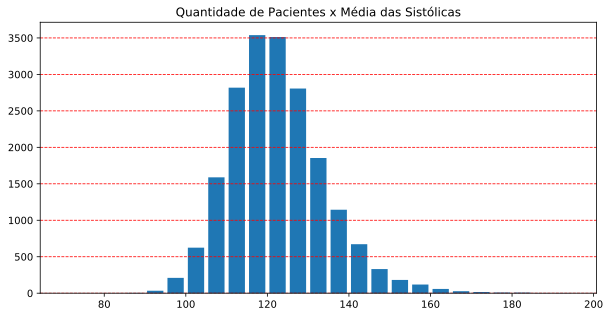

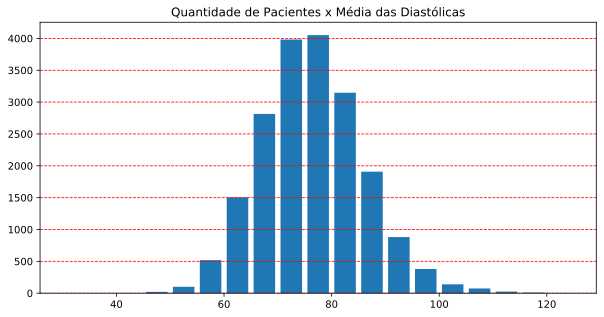

<Figure size 720x360 with 0 Axes>

In [7]:
# Plota a Quantidade de pacientes x Faixa de PASs Média
plt.grid(axis="y", linestyle="--", color="red")
plt.hist(media_sist, bins=range(70,200,5), rwidth=0.8)
plt.title("Quantidade de Pacientes x Média das Sistólicas")
plt.show()
plt.savefig (DIRETORIO_PRINCIPAL / "graficos" / "graficos_media_PAs" / "media_todas_sistolicas_por_qtds_pacientes.svg")


# Plota a Quantidade de pacientes x Faixa de PADs Média
plt.grid(axis="y", linestyle="--", color="red")
plt.hist(media_diast, bins=range(30,130,5), rwidth=0.8)
plt.title("Quantidade de Pacientes x Média das Diastólicas")
plt.show()
plt.savefig (DIRETORIO_PRINCIPAL / "graficos" / "graficos_media_PAs" / "media_todas_diastolicas_por_qtds_pacientes.svg")


In [8]:
#Padrão AMBULATORY HIPOTENSION
# if any SBP <90 or any DBP <60

#Padrão ISOLATED SYSTOLIC
# if any SBP >140 and 60< DBP <90 

#Padrão ISOLATED DIASTOLIC
# if all 100< SBP <140 and any DBP >90

#Padrão DIPPING
# calcular SPB diurna
# calcular SBP noturna
# calcular dif=% da SBP noturna comparado com a diurna
# if 10< dif < 20 then DIPPING
# if dif < 10 then NON DIPPING (BLUNTED)
# if dif > 20 then EXTREME DIPPING
#Padrão REVERSE DIPPING
# if SBP Noturna >= SBP Diurna

#Padrão MASKED
# if 100 < ~NOTURNO < 140 and (NOTURNO any SBP>=140)
#     informar qtde de medidas >=140

#Padrão MORNING SURGE
# if DIPPING, calcular SBP matinal
#      if SBP matinal > 10% da SBP Noturna

#Padrão White-Coat
# if a média das 4 1as. medidas de PAS forem > a média de todas as medidadas da Sistólica de todos os outros turnos
# OU
# if a média das 4 1as. medidas de PAD forem > a média de todas as medidadas da Diastólica de todos os outros turnos

# Normotenso - Todas as diastólicas e sitólicas dentro das faixas normais (100, 140) e (60, 90)



In [9]:
# Cria o cabeçalho com o nome das doenças

lista_nomes_doencas=['Hipotensão Ambulatorial','Sistólica Isolada','Diastólica Isolada','Dipping','Non Dipping','Extreme Dipping','Reverse Dipping','Morning Surge','Masked', 'Whitecoat','Normotenso']

In [10]:
np.mean(np.array([20, math.nan, 30]))

nan

In [11]:
#Padrão AMBULATORY HIPOTENSION
# if any SBP <100 or any DBP <60

#  qtd_limiar define qtd de medidas abaixo dos valores de referência (VR) para considerar episódio de Hipotensão

def hipotensao_ambulatorial (sistolica,diastolica, qtd_limiar=1):
    min_sist=np.min(sistolica)
    min_diast=np.min(diastolica)
    
    # Positivo se pelo menos qtd_limiar medidas estão abaixo do limiar
    # return (min_sist < 100 or min_diast < 60):
    return (sum(sistolica < 100) >= qtd_limiar or sum(diastolica < 60) >= qtd_limiar)

In [12]:
#Padrão HIPERTENSÃO ISOLATED SYSTOLIC
# if any SBP >140 and 60< DBP <90 

def sistolica_isolada(sistolica, diastolica, max_sist=140, min_diast=60, max_diast=90):
    # A função "max" não funciona quando há qualquer "Nan" na série
    max_sistolica=np.max(sistolica)    
    return (max_sistolica > max_sist) and all(min_diast <=  valor <= max_diast for valor in diastolica)
    

In [13]:
#Padrão HIPERTENSÃO ISOLATED DIASTOLIC
# if all 100< SBP <140 and any DBP >90

def diastolica_isolada(sistolica, diastolica, min_sist=100, max_sist=140, max_diast=90):
    max_diastolica=np.max(diastolica)
    return (max_diastolica > max_diast) and all(min_sist <=  valor <= max_sist for valor in sistolica)
    


In [14]:
#Padrão DIPPING
# calcular SPB diurna
# calcular SBP noturna
# calcular dif=% da SBP noturna comparado com a diurna
# if 10< dif < 20 then DIPPING
# if dif < 10 then NON DIPPING (BLUNTED)
# if dif > 20 then EXTREME DIPPING
#Padrão REVERSE DIPPING
# if SBP Noturna >= SBP Diurna

#############################################################################################
#  Qtas medidas fora do VR para considerar Non Dipping ???????
#############################################################################################

def calcula_diferenca_percentual(diurno,matutino,vespertino,noturno):
    # Como as medidas estão vindo como "pd.Series", a chamada "mean" lida corretametne
    # com os valores "NaN" (ignora-os)
    media_aritmetica_diurno=np.mean(np.concatenate((matutino, diurno, vespertino)))
    media_aritmetica_noturno=np.mean(noturno)
    diferenca_percentual=(media_aritmetica_diurno/media_aritmetica_noturno)
    return diferenca_percentual


def dipping(diferenca_percentual):
    if (1.1 < diferenca_percentual < 1.2) :
        return True
    else:
        return False

def non_dipping(diferenca_percentual):
    if (1 < diferenca_percentual <= 1.1) :
        return True
    else:
        return False
    
def extreme_dipping(diferenca_percentual):
    if (diferenca_percentual >= 1.2) :
        return True
    else:
        return False   
    
def reverse_dipping(diferenca_percentual):
    if (diferenca_percentual <= 1) :
        return True
    else:
        return False   
                     

In [15]:
i = mapas[mapas["numero_identificacao"]==14583].index[0]

parametros = [x.dropna() for x in [sist_diurno.iloc[i,:], sist_matutino.iloc[i,:],sist_vespertino.iloc[i,:],sist_noturno.iloc[i,:]] ]
print(i)
print(calcula_diferenca_percentual(*parametros))
print(dipping(calcula_diferenca_percentual(*parametros)))

# if numero_identificacao == 184
#    print (diferenca_percentual)

13140
1.166737079284608
True


In [16]:
all(pd.Series([10,20,30, math.nan])  < 100 )

False

In [17]:
#Padrão MASKED
# if 100 < Sistólica ~NOTURNO < 140 and (NOTURNO any SBP>=140)
#############################################################################
#     informar qtde de medidas >=140
##############################################################################
def masked(sist_dia, sist_noturno, paciente_whitecoat):
    if paciente_whitecoat:
        return False
    sist_dia = sist_dia.dropna()
    sist_noturno = sist_noturno.dropna()
    return  all(100 <= sist_dia) and all(sist_dia <= 140) and any(sist_noturno >= 140)
 

In [18]:
#Padrão MORNING SURGE
# if DIPPING, calcular SBP matinal
#      if SBP matinal > 10% da SBP Noturna

def morning_surge(matutino, noturno, diagnostico_dipping):
    if not diagnostico_dipping:
        return None, None, None, False
    # Entra aqui se for Dipping
    media_matutino=np.mean(matutino)
    media_noturno=np.mean(noturno) 
    fator_de_morning_surge = media_matutino / media_noturno
    return media_matutino, media_noturno, fator_de_morning_surge, fator_de_morning_surge > 1.1 

        

In [19]:

all(sist_dia.iloc[200, :].dropna() < 200)

True

In [20]:
# Whitecoat
# if any das 4 1as. medidas de PAS/PAD forem > que os valores de referências (VR)
#
def whitecoat(dados_whitecoat):
    # Os dados de whitecoat vem no arquivo CSV como um texto
    # representando uma lista de Python. Cada elemento da lista é uma tupla
    # com 3 dados: o horário, no formato h:mm, pressao sistólica e pressão diastólica.
    nan = math.nan
    dados = eval(dados_whitecoat)
    # print(dados)
    for horario, sist, diast in dados:
        if not math.isnan(sist) and (sist < 100 or sist > 140):
            return True
        if not math.isnan(diast) and (diast < 60 or diast > 90):
            return True
    return False
     
# verifica_whitecoat(mapas.iloc[4, :].loc["whitecoat"])

In [21]:
# Normotenso - Todas as sistólicas e diastólicas dentro dos Valores de Referência (100, 140) e (60, 90)

def normotenso(sistolica, diastolica):
    sistolica = sistolica.dropna()
    diastolica = diastolica.dropna()
    return (all(sistolica <= 140) and all(sistolica >= 100)) and (all(diastolica <= 90) and all(diastolica >= 60))
        

In [22]:
#    lista_hipotensao.append(hipotensao_ambulatorial(sistolica_paciente,diastolica_paciente))
#    lista_sistolica_isolada.append(sistolica_isolada(sistolica_paciente,diastolica_paciente))
#    lista_diastolica_isolada.append(diastolica_isolada(sistolica_paciente,diastolica_paciente))
#    lista_dipping.append(dipping(sist_diurno.iloc[i,:],sist_matutino.iloc[i,:],sist_vespertino.iloc[i,:],sist_noturno.iloc[i,:]))
#    lista_non_dipping.append(non_dipping(sist_diurno.iloc[i,:],sist_matutino.iloc[i,:],sist_vespertino.iloc[i,:],sist_noturno.iloc[i,:]))
#    lista_extreme_dipping.append(extreme_dipping(sist_diurno.iloc[i,:],sist_matutino.iloc[i,:],sist_vespertino.iloc[i,:],sist_noturno.iloc[i,:]))
#    lista_reverse_dipping.append(reverse_dipping(sist_diurno.iloc[i,:],sist_matutino.iloc[i,:],sist_vespertino.iloc[i,:],sist_noturno.iloc[i,:]))
#    lista_masked.append(masked(sist_dia.iloc[i, :], sist_noturno.iloc[i,:]))
#    lista_morning_surge.append(morning_surge(sist_diurno.iloc[i,:],sist_matutino.iloc[i,:],sist_vespertino.iloc[i,:],sist_noturno.iloc[i,:]))
#    lista_whitecoat.append(verifica_whitecoat(mapas.iloc[i, :].loc["whitecoat"]))
#    lista_normotenso.append(normotenso(sistolica_paciente, diastolica_paciente))

In [23]:
mapas.loc[5:20, ["numero_identificacao"]]

numero_identificacao
5                      9
6                     10
7                     11
8                     12
9                     13
10                    14
11                    15
12                    17
13                    18
14                    19
15                    20
16                    21
17                    22
18                    23
19                    24
20                    25

In [24]:
# Celula de teste, para inspecionar o funcionamento do calculo de morning surge

i = 9
sistolica_por_periodo = [
    x.dropna() 
    for x in (sist_diurno.iloc[i,:], sist_matutino.iloc[i,:],sist_vespertino.iloc[i,:],sist_noturno.iloc[i,:])
]
diferenca_percentual_i = calcula_diferenca_percentual(*sistolica_por_periodo)
tmp_dipping = dipping(diferenca_percentual_i)
resultado = morning_surge(sistolica_por_periodo[1], 
                          sistolica_por_periodo[3],
                          diagnostico_dipping=tmp_dipping)

print(resultado)

(126.875, 103.64285714285714, 1.2241557546519641, True)


## Arquivo com Diagnósticos

In [25]:
# Roda todas as funções para classificar os pacientes de acordo com a doença diagnosticada  
lista_diferenca_percentual = []
lista_diferenca_morning_surge = []
lista_media_noturno = []
lista_media_matutino = []
lista_hipotensao=[]
lista_sistolica_isolada=[]
lista_diastolica_isolada=[]
lista_dipping=[]
lista_non_dipping=[]
lista_extreme_dipping=[]
lista_reverse_dipping=[]
lista_masked=[]
lista_morning_surge=[]
lista_whitecoat=[]
lista_normotenso=[]


for i in range(np.size(mapas,0)):
    # trata o NaNs para que as funções de cálculo funcione
    sistolica_paciente = sist.iloc[i, :].dropna()
    diastolica_paciente = diast.iloc[i, :].dropna()
    
    # Na chamada da função, o prefixo "*" indica que cada elemento da sequência é passado como um
    # argumento na mesma ordem.
    sistolica_por_periodo = [
        x.dropna() 
        for x in (sist_diurno.iloc[i,:], sist_matutino.iloc[i,:],sist_vespertino.iloc[i,:],sist_noturno.iloc[i,:])
    ]
    
    diferenca_percentual_i = calcula_diferenca_percentual(*sistolica_por_periodo)

    lista_hipotensao.append (hipotensao_ambulatorial(sistolica_paciente,diastolica_paciente))
    lista_sistolica_isolada.append (sistolica_isolada(sistolica_paciente,diastolica_paciente))
    lista_diastolica_isolada.append (diastolica_isolada(sistolica_paciente,diastolica_paciente))
    tmp_dipping = dipping(diferenca_percentual_i)
    lista_dipping.append (tmp_dipping)
    lista_non_dipping.append (non_dipping(diferenca_percentual_i))
    lista_extreme_dipping.append (extreme_dipping(diferenca_percentual_i))
    lista_reverse_dipping.append (reverse_dipping(diferenca_percentual_i))
    this_is_whitecoat = whitecoat(mapas.iloc[i, :].loc["whitecoat"])
    lista_masked.append (masked(sist_dia.iloc[i, :].dropna(), sistolica_por_periodo[3], this_is_whitecoat))
    tmp_valores_morning_surge = morning_surge(sistolica_por_periodo[1], 
                                               sistolica_por_periodo[3],
                                               diagnostico_dipping=tmp_dipping)

    
    # Pega o último valor retornado pela função "morning_surge" que é o resultado booleano da ocorrência da doença
    lista_morning_surge.append (tmp_valores_morning_surge[-1])
    lista_whitecoat.append (this_is_whitecoat)
    lista_normotenso.append (normotenso(sistolica_paciente, diastolica_paciente))
     
    # Valores intermediários para propósitos de validação dos cálculos:
    
    lista_diferenca_percentual.append(diferenca_percentual_i)
    lista_diferenca_morning_surge.append(tmp_valores_morning_surge[2])
    lista_media_matutino.append(tmp_valores_morning_surge[0])
    lista_media_noturno.append(tmp_valores_morning_surge[1])
    ###############################################################################################################
  
mapas['Hipotensao']=lista_hipotensao
mapas['Sistolica Isolada']=lista_sistolica_isolada
mapas['Diastolica Isolada']=lista_diastolica_isolada
mapas['Dipping']=lista_dipping
mapas['Non Dipping']=lista_non_dipping
mapas['Extreme Dipping']=lista_extreme_dipping
mapas['Reverse Dipping']=lista_reverse_dipping
mapas['Morning Surge']=lista_morning_surge
mapas['Masked']=lista_masked
mapas['Whitecoat']=lista_whitecoat  # Os dados "brutos" estão na coluna "whitecoat" (com "w" minúsculo)
mapas['Normotenso']=lista_normotenso

coluna_diferenca_percentual = pd.Series(lista_diferenca_percentual)
coluna_diferenca_percentual.name = "Diferença % Dipping"
coluna_diferenca_morning_surge = pd.Series (lista_diferenca_morning_surge)
coluna_diferenca_morning_surge.name = "Diferença % Morning Surge"
coluna_media_matutino = pd.Series(lista_media_matutino)
coluna_media_matutino.name = "Média matutino"
coluna_media_noturno = pd.Series(lista_media_noturno)
coluna_media_noturno.name = "Média noturno"


#  Cria csv com o diagnóstico das doenças de cada paciente

mapas.to_csv(path_or_buf=DIRETORIO_PRINCIPAL / "padrao_doenca" / 'classificados_por_padroes_de_doenca.csv',
             sep=';',index=False,encoding='latin1')


In [26]:
# Se ainda existir a coluna "unnamed", remove-a.
if ("Unnamed: 0" in mapas):
    mapas.drop("Unnamed: 0", 1, inplace=True)


## Arquivo com a Diferença Percentual

In [27]:
# Cria arquivo Excel com a coluna "diferenca percentual" explícita

# Formatação do arquivo Excel creating a Pandas Excel writer using XlsxWriter as the engine
writer = pd.ExcelWriter(DIRETORIO_PRINCIPAL / "padrao_doenca" / 'diferenca_percentual.xlsx', engine='xlsxwriter')

mapas_colunas_extras = pd.concat((mapas, coluna_diferenca_percentual, coluna_media_matutino, 
                                  coluna_media_noturno, coluna_diferenca_morning_surge), axis=1)

mapas_colunas_extras.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False)

# Get the xlsxwriter workbook and worksheet objects.
workbook  = writer.book
worksheet = writer.sheets['Sheet1']

# Add some cell formats.
formato_coluna_porcentagem = workbook.add_format({
    'num_format': '0.00%'
})

formato_coluna_milhar = workbook.add_format({
    'num_format': '0.00'
})

formato_cabecalho = workbook.add_format({
    'bold': True,
    'text_wrap': True,
    'valign': 'top',
    'fg_color': '#D7E4BC'
})

# Set column width and format
worksheet.set_column('B:B', 20)
worksheet.set_column('C:C', 16)
worksheet.set_column('D:G', 7)
worksheet.set_column('H:H', 18)
worksheet.set_column('I:FP', 10)
worksheet.set_column('FQ:FQ', 50)
worksheet.set_column('FR:GC', 12)
worksheet.set_column('GD:HA', 17)
worksheet.set_column('HB:HB', 14, formato_coluna_porcentagem)
worksheet.set_column('HC:HD', 15, formato_coluna_milhar)
worksheet.set_column('HE:HE', 15, formato_coluna_porcentagem)


# Write the column headers with the defined format.
for num_col, valor in enumerate(mapas_colunas_extras.columns.values, 1):
    worksheet.write(0, num_col, valor, formato_cabecalho)

# Close the Pandas Excel writer and output the Excel file.
writer.save()


## Casos Fora do Padrão Conhecido

In [28]:
#   Identifica os casos fora dos padrões conhecidos da literatura

def encontra_fora_do_padrao(linha):
    return not linha.loc["Hipotensao": "Normotenso"].any()

fora_dos_padroes = mapas.apply(encontra_fora_do_padrao, axis=1)

# Insere a coluna Fora do Padrão no csv
mapas.insert(mapas.columns.get_loc('Normotenso') + 1, 'Fora Padrões', fora_dos_padroes)
sum(fora_dos_padroes)

0

In [29]:
#mapas.head()
# mapas[mapas["Extreme Dipping"]].loc[:, 'Whitecoat':]
sum(mapas["Masked"])

32

In [30]:
#import sys
#sys.version_info
####################################################################################################
# Precisa ser instalado separadamente para salvar arquivos Excel (.xlsx) diretamente do Pandas
####################################################################################################
# !pip install xlsxwriter

## Qtd de Pacientes e % de diagnosticados em cada padrão

In [31]:

# Contagem da qtd de pacientes e percentual de diagnosticados em cada padrão de doença

def cria_arquivo_padroes_doenca():
    total_pacientes = mapas.shape[0]
    totais = []
    for nome_doenca, diagnostico in mapas.loc[:, 'Hipotensao': 'Fora Padrões'].iteritems():
        total = sum(diagnostico.values)
        totais.append((nome_doenca, total, total_pacientes - total, total / total_pacientes))
        
    totais.append(("Total", total_pacientes, 0, 1))
        
    # print(totais)
    df_totais = pd.DataFrame(totais, columns = ['Padrão de Doença', 'Diagnóstico', 'Isento', 'Percentual de Positivos'])
    # print(df_totais)
    arquivo_padroes_doenca = DIRETORIO_PRINCIPAL / "quantitativos" / 'qtd_por_padroes_de_doenca.xlsx'
    
    # Formatação do arquivo Excel 
    # Create a Pandas Excel writer using XlsxWriter as the engine
    writer = pd.ExcelWriter(arquivo_padroes_doenca, engine='xlsxwriter')

    # Convert the dataframe to an XlsxWriter Excel object.
    df_totais.to_excel(writer, sheet_name='Sheet1', index=False)

    # Get the xlsxwriter workbook and worksheet objects.
    workbook  = writer.book
    worksheet = writer.sheets['Sheet1']
    

    # Add some cell formats.
    # format1 = workbook.add_format({'num_format': '#,##0.00'})
    formato_percentual = workbook.add_format({'num_format': '0.000%'})

    # Note: It isn't possible to format any cells that already have a format such
    # as the index or headers or any cells that contain dates or datetimes.

    # Set the column width and format.
    worksheet.set_column('D:D', None, formato_percentual)
    worksheet.set_column('A:A', 20, None)
    worksheet.set_column('B:B', 15, None)
    worksheet.set_column('C:C', 12, None)
    worksheet.set_column('D:D', 20, None)

    # Close the Pandas Excel writer and output the Excel file.
    writer.save()

cria_arquivo_padroes_doenca()

      
        
# quantitativo_por_padrao=pd.DataFrame(list(zip(lista_nomes_doencas[0:len(lista_nao_atendidos)],lista_atendidos,lista_nao_atendidos)),columns=['Padrao de Doenca','Diagnosticado','Isento'])
# quantitativo_por_padrao.to_csv(path_or_buf='D:\Projeto_PA\\quantitativos\\qtd_por_padroes_de_doenca.csv',sep=';',index=False,encoding='UTF-8')

#desenha_linhas(plt)
#plt.plot(np.arange(80),sist.iloc[1,:])
#plt.plot(np.arange(80),diast.iloc[1,:])
#mapas.to_csv(path_or_buf='D:\Projeto_PA\\dataset_modificado\\dataset_padroes_diagnosticado.csv',sep=';',index=False,encoding='UTF-8')

In [32]:
mapas.loc[:, "Hipotensao":"Normotenso"].columns

Index(['Hipotensao', 'Sistolica Isolada', 'Diastolica Isolada', 'Dipping',
       'Non Dipping', 'Extreme Dipping', 'Reverse Dipping', 'Morning Surge',
       'Masked', 'Whitecoat', 'Normotenso'],
      dtype='object')

In [33]:
# import numpy  as np
# 
# def cria_func(a, b, c):
#     def func(x):
#         return a * x ** 2 + b*x +c
#     return func
# 
# y = cria_func(5, 3, -10)
# y1 = cria_func(4, 2, -8)
# 
# data_x = np.arange(-5, 5, .1)
# data_y = []
# data_y1 = []
# 
# 
# for elemento in data_x:
#     data_y.append(y(elemento))
#     data_y1.append(y1(elemento))
# 
# dados = pd.DataFrame(list(zip(data_y, data_y1)), columns=["func y", "func y1"], index=data_x)  
# print( dados)
# for indice, linha in dados.iterrows():
#     print(indice, list(linha))
#     if  math.isclose(indice, -4.5):
#         break
        # math.iscolose 
#plt.plot(data_x, data_y)
#plt.show()
# plt.plot(data_x, data_y1)

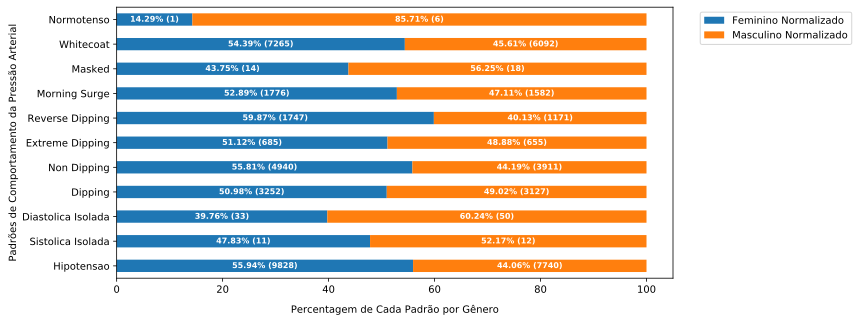

                    Feminino  Masculino  Feminino Normalizado  \
Hipotensao              9828       7740             55.942623   
Sistolica Isolada         11         12             47.826087   
Diastolica Isolada        33         50             39.759036   
Dipping                 3252       3127             50.979777   
Non Dipping             4940       3911             55.812902   
Extreme Dipping          685        655             51.119403   
Reverse Dipping         1747       1171             59.869774   
Morning Surge           1776       1582             52.888624   
Masked                    14         18             43.750000   
Whitecoat               7265       6092             54.390956   
Normotenso                 1          6             14.285714   

                    Masculino Normalizado  
Hipotensao                      44.057377  
Sistolica Isolada               52.173913  
Diastolica Isolada              60.240964  
Dipping                         49.020223  

In [34]:
# Plota gráfico de Barras horizontal por Doença e Gênero com seus quantitativos e percentuais

def monta_dados_grafico(mapas):
    nome_eixo=[]
    qtd_genero_fem=[]
    qtd_genero_masc=[]
    for nome_coluna in mapas.loc[:, "Hipotensao":"Normotenso"].columns:
        pacientes_que_atendem_criterio=mapas.loc[mapas[nome_coluna]]
        if (pacientes_que_atendem_criterio['genero'].value_counts().empty==False):
            qtd_genero_masc.append(pacientes_que_atendem_criterio['genero'].value_counts()['M'])
            qtd_genero_fem.append(pacientes_que_atendem_criterio['genero'].value_counts()['F'])
            nome_eixo.append(nome_coluna)

    df_grafico = pd.DataFrame(list(zip(qtd_genero_fem,qtd_genero_masc)),columns=['Feminino','Masculino'],index=nome_eixo)
    # df_grafico.reindex(nome_eixo)
    return df_grafico
    

def plota_graficos_por_doenca(dados_grafico):
        fig, axs = plt.subplots(1) 
        grafico = dados_grafico[["Feminino Normalizado", "Masculino Normalizado"]].plot.barh(stacked=True, ax=axs)
        axs.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.ylabel('Padrões de Comportamento da Pressão Arterial')
        plt.xlabel('Percentagem de Cada Padrão por Gênero',labelpad=10)
        legenda = partial(grafico.text, color='white', weight='bold', fontsize=8, ha="center", va="center")
        for linha, (doenca, dados_da_linha) in enumerate(dados_grafico.iterrows()):  
            # Busca a 1a.coluna 
            fem = dados_da_linha[0]
            # Busca a 2a. coluna
            masc = dados_da_linha[1]
            fem_p = dados_da_linha[2]
            masc_p = dados_da_linha[3]
            
            # ou poderia ser assim:
            # fem, masc, fem_p, masc_p = dados_da_linha
            
            legenda(fem_p / 2, linha, f"{fem_p:.02f}% ({int(fem)})") 
            legenda(fem_p + masc_p / 2, linha, f"{masc_p:.02f}% ({int(masc)})")
              
            # legenda(dados[2] / 2, linha, f"{dados[2]:.01f}%")
            # legenda(dados[2] + dados[3] / 2, linha, f"{dados[3]:.01f}%" )
             
            #legenda(dados[2] / 2, linha, int(fem) )
            #legenda(dados[2] + dados[3] / 2, linha, int(masc) )
            
            #grafico.text(dados[2] + (100 - dados[2]) / 2, i, int(masc), color='white', weight='bold', fontsize=8, ha="center", va="center")          
        plt.show()



def adiciona_percentagens(grafico_genero_diagnosticado):
    percentual_fem = grafico_genero_diagnosticado.apply(lambda row: row[0] / (row[0] + row[1]) * 100 , axis=1)
    percentual_masc = grafico_genero_diagnosticado.apply(lambda row: row[1] / (row[0] + row[1]) * 100 , axis=1)
    grafico_genero_diagnosticado["Feminino Normalizado"] = percentual_fem
    grafico_genero_diagnosticado["Masculino Normalizado"] = percentual_masc
    
grafico_genero_diagnosticado = monta_dados_grafico(mapas)
adiciona_percentagens(grafico_genero_diagnosticado)
plota_graficos_por_doenca(grafico_genero_diagnosticado)
print (grafico_genero_diagnosticado)

In [35]:

# plota_grafico_por_doenca(grafico_genero_diagnosticado)
    
# grafico_genero_diagnosticado.reindex(nome_eixo)

# Inclui legenda na parte interna da Barra

           
#nome_grafico=grafico_genero_diagnosticado.plot.barh(stacked=True)
#for j in range (grafico_genero_diagnosticado.shape[0]):
#    for i in range (grafico_genero_diagnosticado.shape[1]):
#        # print (qtd_genero_fem)
#        posicao_legenda=[qtd_genero_fem[j]/2, qtd_genero_fem[j]+(qtd_genero_masc[j]/2)]
#        nome_grafico.text(posicao_legenda[i],j, grafico_genero_diagnosticado.iloc[j,i],color='white',weight='bold',fontsize=8,ha="center")
#        plt.xlabel('Quantidade de Medidas Por Tipo de Doença em cada Gênero',labelpad=10)
#        plt.ylabel('Padrões de Doença da Pressão Arterial')
#        plt.savefig('D:\Projeto_PA\\padroes_de_doenca\\grafico_de_barras_pacientes_com '+str(doenca)+'.svg',format="svg")            
   
#fig, axs = plt.subplots(13)
#fig.suptitle('Quantidade de Pacientes Por Tipo de Doença em cada Gênero')
#
##fig.ylabel('Padrões de Doença da Pressão Arterial')
#    
#for j in range (grafico_genero_diagnosticado.shape[0]):
#    grafico=grafico_genero_diagnosticado.iloc[j, :].plot.barh(stacked=True, ax=axs[j])
#    for i in range (grafico_genero_diagnosticado.shape[1]):
#        # print (qtd_genero_fem)
#        posicao_legenda=[qtd_genero_fem[j]/2, qtd_genero_fem[j]+(qtd_genero_masc[j]/2)]
#        grafico.text(posicao_legenda[i],j, grafico_genero_diagnosticado.iloc[j,i],color='white',weight='bold',fontsize=8,ha="center")
#
#
#        # plt.ylabel('Padrões de Doença da Pressão Arterial')
#     
            
# Plota o gráfico
# plt.savefig('D:\Projeto_PA\\padroes_de_doenca\\grafico_de_barras.svg',format="svg")

In [36]:
# Verifica qtd pacientes por doença
pacientes_que_atendem_criterio=mapas.loc[mapas['Masked']==True]
pacientes_que_atendem_criterio['genero'].value_counts()['M']

18

In [37]:
# NOTA ################################################################################# 
# o cálculo de variância e outras medidas do NumPy: Se for passada uma sequencia
# de NaNs do Python, basta um único valor NaN para o cálculo resultar em NaNs e dar errado.
# No entanto, se for passada uma série, os valores NaN são automaticamente descartados.
# Examples comprabatórios abaixo
########################################################################################

x = [3, 5, 3, 5, 4, float("NaN"), 4 ]

print(np.var(x), np.var(pd.Series(x)))
print(np.mean(x), np.mean(pd.Series(x)))
                          
# Para a área sob a curva (trapz) e mediana, basta um únco NaN para invalidar o cálculo
print("****")
print(np.trapz(pd.Series(x)))
print(np.median(x), np.median(pd.Series(x)))

y = pd.Series(x)
y.iloc[-1]
import math
math.isnan

nan 0.6666666666666666
nan 4.0
****
nan
nan nan


<function math.isnan>

In [38]:
# np.round(sist.apply(lambda row: np.median(row.dropna()), axis=1) )
# O lambda é equivalente a ter uma função no local:

def mediana_sem_nan(linha):
    return np.median(linha.dropna())

# np.round(sist.apply(mediana_sem_nan, axis=1) )


## Interpolação 

(5, 145.0)

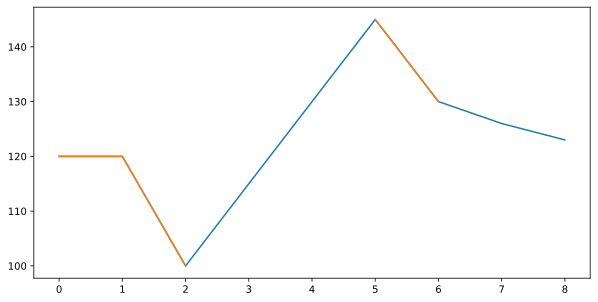

In [39]:
# Para calcular Mediana, AUC e AUC PP é preciso que os valores NaNs sejam tratados, pois do contrário
# o cálculo não é realizado. 
# Aqui tem as funções para interpolar as medidas faltantes e desenhar uma reta entre os pontos. E, é preciso 
# tratar de forma diferente os NanS da 1a. e última coluna.
# Com esses valores preenchidos, é possível calcular a AUC
#

def olha_pra_tras(linha, indice):
    """devolve o último índice e  valores válidos, antes do indice recebido """
    indice = indice - 1

    # pd.Series: precisa do iloc para funcionar com indices negativos
    while math.isnan(linha.iloc[indice]):
        indice -= 1
    return indice, linha.iloc[indice]

def olha_pra_frente(linha, indice):
    """devolve o próximo índice e  valores válidos, antes do indice recebido, "dando a volta" depois do último """
    indice = indice + 1

    # pd.Series: precisa do iloc para funcionar com indices negativos
    while math.isnan(linha.iloc[indice % len(linha)]):
        indice += 1
    return indice, linha.iloc[indice % len(linha)]


def interpola_sem_as_pontas(linha):
    """Dada uma ou mais medidas contendo NaN, interpola
    valores ligando uma reta entre as medidas imediatamente
    anterior e posterior à lacuna
    """
    linha = linha.copy()
    inicio_lacuna = None
    ultimo_valor_valido = None
    ultimo_indice_valido = None
    valor_anterior = 0
    

    
    for indice, valor in enumerate(linha):
        if math.isnan(valor):
            if indice == 0:
                # caso especial - tem que interpolar com valores de antes das 9h00
                pass
            elif inicio_lacuna is not None:
                pass
            else:
                # Primeiro NaN em uma lacuna
                ultimo_valor_valido = valor_anterior
                ultimo_indice_valido = indice - 1
                inicio_lacuna = indice
        elif inicio_lacuna is not None:
            # primeiro número encontrado após uma lacuna
            b = ultimo_valor_valido
            a = (valor - ultimo_valor_valido) / (indice - ultimo_indice_valido)
            for j in range(ultimo_indice_valido + 1, indice):
                x = j - ultimo_indice_valido
                linha[j] = a * x + b
                
            
            inicio_lacuna = None
            ultimo_indice_valido = None
                
        valor_anterior = valor
        # para fazer: se termina a linha dentro de uma lacuna
    return linha

def interpola_lacuna(linha, indice_anterior, valor_valido_anterior, indice, valor):
    b = valor_valido_anterior
    a = (valor - b) / (indice - indice_anterior)
    for j in range(indice_anterior + 1, indice):
        x = j - indice_anterior
        linha[j % len(linha)] = int(a * x + b)

def interpola(linha):
    """Dada uma ou mais medidas contendo NaN, interpola
    valores ligando uma reta entre as medidas imediatamente
    anterior e posterior à lacuna
    """
    linha = linha.copy()
    inicio_lacuna = None
    ultimo_valor_valido = None
    ultimo_indice_valido = None
    valor_anterior = 0
    
    for indice, valor in enumerate(linha):
        if math.isnan(valor_anterior) and not math.isnan(valor):
            indice_anterior, valor_valido_anterior = olha_pra_tras(linha, indice)
            interpola_lacuna(linha, indice_anterior, valor_valido_anterior, indice, valor)
            
        valor_anterior = valor
            
    # para fazer: se termina a linha dentro de uma lacuna
    if math.isnan(valor):
        # se o ultimo valor é um nan - o dia acaba dentro de uma lacuna:
        indice, valor = olha_pra_tras(linha, indice)
        
        proximo_indice, proximo_valor = olha_pra_frente(linha, indice)
        interpola_lacuna(linha, indice, valor, proximo_indice, proximo_valor)
        
    return linha
            
    
v1 = pd.Series([120, 120, 100, math.nan, math.nan, 145, 130, math.nan, math.nan])
v2 = interpola(v1)
plt.plot(v2.index, v2)
plt.plot(v1.index, v1)

olha_pra_frente(v1, 4)


In [40]:
    
sist_interpolado = sist.apply(interpola, axis=1)
diast_interpolado = diast.apply(interpola, axis=1)


sist_matutino_interpolado = sist_interpolado.loc[:,'sist 6:00':'sist 8:45']
sist_diurno_interpolado = sist_interpolado.loc[:,'sist 9:00':'sist 20:45']
sist_vespertino_interpolado = sist_interpolado.loc[:,'sist 21:00':'sist 22:45']
sist_noturno_interpolado = sist_interpolado.loc[:,'sist 23:00':'sist 5:30']
diast_matutino_interpolado = diast_interpolado.loc[:,'diast 6:00':'diast 8:45']
diast_diurno_interpolado = diast_interpolado.loc[:,'diast 9:00':'diast 20:45']
diast_vespertino_interpolado = diast_interpolado.loc[:,'diast 21:00':'diast 22:45']
diast_noturno_interpolado = diast_interpolado.loc[:,'diast 23:00':'diast 5:30']

sist_daytime_interpolado = pd.concat([sist_matutino_interpolado, sist_diurno_interpolado, sist_vespertino_interpolado], axis=1)
diast_daytime_interpolado = pd.concat([diast_matutino_interpolado, diast_diurno_interpolado, diast_vespertino_interpolado], axis=1)



## Estatísticas

In [41]:
# Cálculo da Média e da Variância total das PAs e PADs e em cada período
# VARIABILIDADE ABSOLUTA é a variância do conjunto em termos de desvios quadrados em relação à média aritmética

# Cálculo da Média PASs e PADs nas 24h
media_sist=np.round(np.mean(sist,axis=1),2)
media_diast=np.round(np.mean(diast,axis=1),2)

# Cálculo da Média PASs e PADs em cada turno
media_sist_diurno=np.round(np.mean(sist_diurno,axis=1),2)
media_sist_matutino=np.round(np.mean(sist_matutino,axis=1),2)
media_sist_vespertino=np.round(np.mean(sist_vespertino,axis=1),2)
media_sist_noturno=np.round(np.mean(sist_noturno,axis=1),2)
#
media_diast_diurno=np.round(np.mean(diast_diurno,axis=1),2)
media_diast_matutino=np.round(np.mean(diast_matutino,axis=1),2)
media_diast_vespertino=np.round(np.mean(diast_vespertino,axis=1),2)
media_diast_noturno=np.round(np.mean(diast_noturno,axis=1),2)

# Cálculo da Média PASs e PADs Daytime - concatenado na 1a. célula todas as sist/diast dos períodos de dia 
media_sist_daytime=np.round(np.mean(sist_dia,axis=1),2)
media_diast_daytime=np.round(np.mean(diast_dia,axis=1),2)

# Cálculo da Variância das PASs e PADs em 24h
variancia_sist=np.round(np.var(sist,axis=1),2)
variancia_diast=np.round(np.var(diast,axis=1),2)

# Cálculo da Mediana sem NaNs
mediana_sist=np.round(sist.apply(mediana_sem_nan, axis=1), 2)
mediana_diast=np.round(diast.apply(mediana_sem_nan, axis=1),2)

# Cálculo da AUC com a sistólica e diastólica interpoladas
auc_sist=np.round(np.trapz(sist_interpolado,axis=1),2)
auc_diast=np.round(np.trapz(diast_interpolado,axis=1),2)

# Cálculo Pressão do Pulso durante o dia e durante a noite com sistólica e diastólica interpoladas
pp_noite = sist_noturno_interpolado.values - diast_noturno_interpolado.values
pp_dia = sist_daytime_interpolado.values - diast_daytime_interpolado.values

# Cálculo da AUC da Pressão de Pulso durante o dia e durante a noite
auc_pp_noite=np.round(np.trapz(pp_noite,axis=1),2)
auc_pp_dia=np.round(np.trapz(pp_dia,axis=1),2)

# Cálculo do Desvio Padrão - DP
dp_sist=np.round(np.std(sist,axis=1),2)
dp_diast=np.round(np.std(diast,axis=1),2)

mapas['Media Sistolica em 24h']=media_sist
mapas['Media Diastolica em 24h']=media_diast
#
mapas['Media Sistolica Diurna']=media_sist_diurno
mapas['Media Sistolica Matutina']=media_sist_matutino
mapas['Media Sistolica Vespertina']=media_sist_vespertino
mapas['Media Sistolica Daytime']=media_sist_daytime
mapas['Media Sistolica Nighttime']=media_sist_noturno
#
mapas['Media Diastolica Diurna']=media_diast_diurno
mapas['Media Diastolica Matutina']=media_diast_matutino
mapas['Media Diastolica Vespertina']=media_diast_vespertino
mapas['Media Diastolica Daytime']=media_diast_daytime
mapas['Media Diastolica Nighttime']=media_diast_noturno
#
mapas['Variancia Sistolica em 24h']=variancia_sist
mapas['Variancia Diastolica em 24h']=variancia_diast
#
mapas['Mediana Sistolica em 24h']=mediana_sist
mapas['Mediana Diastolica em 24h']=mediana_diast
#
mapas['AUC Sistolica em 24h']=auc_sist
mapas['AUC Diastolica em 24h']=auc_diast
#
mapas['AUC PP Daytime']=auc_pp_dia
mapas['AUC PP Nighttime']=auc_pp_noite
#
mapas['DP Sistolica em 24h']=dp_sist
mapas['DP Diastolica em 24h']=dp_diast

mapas.to_csv(path_or_buf= DIRETORIO_PRINCIPAL / "padrao_doenca" / 'classificados_por_padroes_de_doenca_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')

mapas.head ()


numero_identificacao data_nascimento genero  idade   peso altura  \
0                     4      1923-10-05      M   94.0   85.0    160   
1                     5      1948-10-07      M   70.0   80.0    165   
2                     6      1999-03-23      M   19.0  100.0    197   
3                     7      1978-01-26      F   40.0   65.0   1,64   
4                     8      1990-03-07      M   28.0  120.0    172   

            data_exame  sist 9:00  sist 9:15  sist 9:30  ...  \
0  2018-09-10 12:25:23      105.0      108.0      116.0  ...   
1  2018-12-26 07:39:41      103.0      114.0       82.0  ...   
2  2018-12-26 08:06:19      147.0      148.0      156.0  ...   
3  2018-12-26 08:19:06      140.0      139.0      142.0  ...   
4  2018-12-26 08:26:59        NaN      110.0      101.0  ...   

   Variancia Sistolica em 24h  Variancia Diastolica em 24h  \
0                      273.06                       129.00   
1                       56.33                        44.22   
2                      161.41                       169.22   
3                      260.18                       106.84   
4                      150.46                       163.67   

   Mediana Sistolica em 24h  Mediana Diastolica em 24h  AUC Sistolica em 24h  \
0                     118.5                       59.0                9545.5   
1                     106.0                       62.0                8586.5   
2                     133.0                       79.0               10674.0   
3                     131.0                       80.0               10679.5   
4                     115.0                       78.0                9141.5   

   AUC Diastolica em 24h  AUC PP Daytime  AUC PP Nighttime  \
0                 4902.0          3748.0             841.5   
1                 5034.5          2915.0             606.0   
2                 6154.0          3721.0             751.5   
3                 6420.5          3642.0             602.5   
4                 6118.0          2405.0             566.0   

   DP Sistolica em 24h  DP Diastolica em 24h  
0                16.52                 11.36  
1                 7.51                  6.65  
2                12.70                 13.01  
3                16.13                 10.34  
4                12.27                 12.79  

[5 rows x 206 columns]

In [42]:
# Dataset contendo apenas pacientes idosos (idade >= 60 anos)
pacientes_idosos = mapas[mapas["idade"] >= 60]
pacientes_idosos.to_csv(path_or_buf = DIRETORIO_PRINCIPAL / "padrao_doenca" / 'idosos_classificados_por_padroes_de_doenca_estatistica.csv', 
             sep=';',index=False,encoding='UTF-8')


In [43]:
##############################################################################################
#
#      Validar contagem de picos 
#
################################################################################################

# Conta a quantidade de Picos = medidas acima do valor de referência

def conta_picos (sistolica, diastolica, sist_max=140, sist_min=100, diast_max=90, diast_min=60) :
    picos_sistolica = 0
    picos_diastolica = 0
    for medida_sist, medida_diast in zip(sistolica, diastolica):
        if medida_sist > sist_max or  medida_sist < sist_min :
            picos_sistolica = picos_sistolica + 1
        if medida_diast > diast_max or  medida_diast < diast_min :
            picos_diastolica = picos_diastolica + 1
    return picos_sistolica, picos_diastolica

lista_picos_sistolica=[]
lista_picos_diastolica=[]
for i in range (np.size(mapas,0)):
    contagem_sistolica, contagem_diastolica = conta_picos (sist.iloc[i,:].dropna(),diast.iloc[i,:].dropna())
    lista_picos_sistolica.append (contagem_sistolica)
    lista_picos_diastolica.append (contagem_diastolica)

mapas['Picos Sistolica']=lista_picos_sistolica
mapas['Picos Diastolica']=lista_picos_diastolica

mapas.to_csv(path_or_buf= DIRETORIO_PRINCIPAL/ "padrao_doenca" / 'classificados_por_padroes_de_doenca_estatistica.csv',
             sep=';',index=False,encoding='UTF-8')  


In [44]:
#help(plt.xlim)

In [45]:
# Função para ser usada internamente nas funções de plotagem:

# Plota as medidas sistólica e diastólica, mas deixando os valores
# interpolados por baixo, com estilo tracejado

def _plota_sist_e_diast_com_valores_interpolados(plt, indice_paciente):
    # desenha as linhas que foram interpoladas
    plt.plot(time_labels, sist_interpolado.loc[indice_paciente, :], linestyle='--')
    plt.plot(time_labels, diast_interpolado.loc[indice_paciente, :], linestyle='--')
    plt.plot(time_labels,sist.loc[indice_paciente,:])  
    plt.plot(time_labels,diast.loc[indice_paciente,:]) 

    

In [46]:
def legenda_com_estatisticas(indice_paciente, colunas_diagnosticos=None):
    
    if colunas_diagnosticos is None:
        colunas_diagnosticos = [
            'Media Sistolica em 24h',
            'Media Diastolica em 24h',
            'Media Sistolica Daytime',
            'Media Diastolica Daytime',
            'Media Sistolica Nighttime',
            'Media Diastolica Nighttime',
            'Mediana Sistolica em 24h',
            'Mediana Diastolica em 24h',
            'Variancia Sistolica em 24h',
            'Variancia Diastolica em 24h',
            'AUC Sistolica em 24h',
            'AUC Diastolica em 24h',
            'AUC PP Daytime',
            'AUC PP Nighttime',
            'DP Sistolica em 24h',
            'DP Diastolica em 24h',
            'Picos Sistolica',
            'Picos Diastolica'
        ]

    estatisticas = []
    for medida in colunas_diagnosticos:
        estatisticas.append(
            f"{medida.replace('stol', 'stól')}: {mapas.loc[indice_paciente, medida]}"
        )
    return '\n'.join(estatisticas)
        
    

In [47]:
# manipulando o código antigo como texto apenas para extrair os nomes das colunas e colar acima:

a = """
    plt.text(ah,145,r'Media Sistólica: '+str(mapas.loc[i,'Media Sistolica em 24h']))
    plt.text(ah,140,r'Media Diastólica: '+str(mapas.loc[i,'Media Diastolica em 24h']))
    plt.text(ah,135,r'Media Sistólica Daytime: '+str(mapas.loc[i,'Media Sistolica Daytime']))
    plt.text(ah,130,r'Media Diastólica Daytime: '+str(mapas.loc[i,'Media Diastolica Daytime']))  
    plt.text(ah,125,r'Media Sistólica Nighttime: '+str(mapas.loc[i,'Media Sistolica Nighttime']))
    plt.text(ah,120,r'Media Diastólica Nighttime: '+str(mapas.loc[i,'Media Diastolica Nighttime']))        

    plt.text(ah,115,r'Mediana Sistólica: '+str(mapas.loc[i,'Mediana Sistolica em 24h']))
    plt.text(ah,110,r'Mediana Diastólica: '+str(mapas.loc[i,'Mediana Diastolica em 24h']))
    plt.text(ah,105,r'Variancia Sistólica: '+str(mapas.loc[i,'Variancia Sistolica em 24h']))
    plt.text(ah,100,r'Variância Diastólica: '+str(mapas.loc[i,'Variancia Diastolica em 24h']))

    plt.text(ah,95,r'AUC Sistólica: '+str(mapas.loc[i,'AUC Sistolica em 24h']))
    plt.text(ah,90,r'AUC Diastólica: '+str(mapas.loc[i,'AUC Diastolica em 24h']))
    plt.text(ah,85,r'AUC PP Daytime: '+str(mapas.loc[i,'AUC PP Daytime']))
    plt.text(ah,80,r'AUC PP Nighttime: '+str(mapas.loc[i,'AUC PP Nighttime'])) 

    plt.text(ah,75,r'Desvio Padrão Sistólica: '+str(mapas.loc[i,'DP Sistolica em 24h']))
    plt.text(ah,70,r'Desvio Padrão Diastólica: '+str(mapas.loc[i,'DP Diastolica em 24h'])) 

    plt.text(ah,65,r'Picos Sistólica: '+str(mapas.loc[i,'Picos Sistolica']))
    plt.text(ah,60,r'Picos Diastólica: '+str(mapas.loc[i,'Picos Diastolica']))
"""
b = [linha.split("'")[-2] for linha in a.split("\n") if linha.strip()]
#  b

In [48]:
# Função unificada de plotagem de gráficos
#  Passa os parâmetros do Título, numero do paciente, posiciona a legenda em função do tipo de gráfico 

mpl.rcParams['figure.dpi'] = 300

def plota_por_id(plt, id, legenda_extra=None,
                 nome_extra='', 
                 title='Gráfico do paciente {id}',
                 diretorio_de_graficos=DIR_GRAFICOS,
                 bbox=None,
                 vline = None,
                ):
    plt.xticks(range(0, len(time_labels), 4), labels=time_labels[::4], fontsize=8)
    paciente_escolhido = mapas.loc[mapas['numero_identificacao'] == id].index[0]
   
    # seleciona as colunas com dados de diagnóstico: busca o paciente numericamente e as colunas por nome    
    
    if legenda_extra:
        #_legenda_com_estatisticas(plt, paciente_escolhido)
    
        # Repassa parametros de box da legenda para a formatação, se houver
        if not bbox:
            bbox_args = {}
        else:
            bbox_args = {"bbox": bbox}
        
        # Legenda posicionada fora do gráfico
        plt.gcf().text(0.92, 0.3, legenda_extra(paciente_escolhido), fontsize=10,
                      **bbox_args)
    
    if vline is True:
        print(time_labels)
        horario = mapas.loc[paciente_escolhido, "data_exame"].split(" ")[1]
        ax = plt.axes()
        ax.axvline(10)

    # desenha as linhas que foram interpoladas
    _plota_sist_e_diast_com_valores_interpolados(plt, paciente_escolhido)

    adiciona_labels(plt)
    prepara_plot(plt)
    plt.title(title.format(id=id))
    ######################################################################################################################
    #          {nome_extra}  com conteúdo estrano: doenca if doenca else
    plt.savefig(diretorio_de_graficos / f'grafico_medidas_paciente_{id}_{nome_extra}.svg',
               bbox_inches="tight", pad_inches=1)
    plt.show()
    

In [50]:
#print(mapas["Picos Diastolica"][10000])
#mapas.loc[10000, "numero_identificacao"]
#plota_por_id(plt, 39, vline=True)
#amostra = [medida for medida in diast.loc[18000, :]  if medida < 60 or medida > 90 ]
#print(len(amostra), amostra)

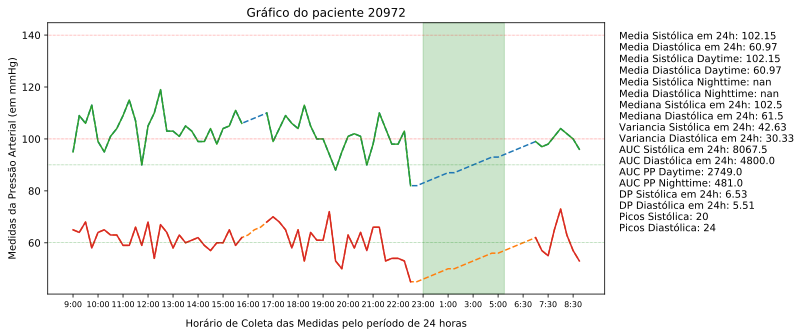

In [52]:
# Gráfico das estatísticas de cada paciente
#
#def grafico_com_estatisticas(plt, id_paciente):
#    plt.xticks(range(0, len(time_labels), 4), labels=time_labels[::4], fontsize=8)
#    paciente_escolhido = mapas.loc[mapas['numero_identificacao'] == id_paciente].index[0] 
#    prepara_plot(plt)
#    # Função que plota as medidas sist e diast, destacanado valores interpolados
#    _plota_sist_e_diast_com_valores_interpolados(plt, paciente_escolhido)
#    # plt.xlim(0,130)
#    print(plt.ylim())
#    # range(0, len(time_labels) => Lista de valores de 10 a 80 com espaçamento de 10
#    plt.xlabel('Horário de Coleta das Medidas',labelpad=10)
#    plt.ylabel('Medidas da Pressão Arterial')
#    plt.title(f'Valores Estatísticos do Paciente {id_paciente}')       
#    _legenda_com_estatisticas(plt, paciente_escolhido)
#
#    plt.savefig(DIR_ESTATISTICAS / f'estatistica_paciente_{id_paciente}.svg',format="svg")       

    
def plota_varios_pacientes(plt, ids, **kwargs):
    # Se o parametro 'ids' veio como um inteiro em vez de ser uma sequência, colocamos ele
    # como únco ID de paciente em uma lista para plotar
    if isinstance(ids, int):  # 'isinstance' checa o tipo de um objeto
        ids = [ids]
    for id in ids:
        plota_por_id(plt, id, **kwargs)
        

def estatisticas_varios_pacientes(ids):
    plota_varios_pacientes(plt, ids, legenda_extra=legenda_com_estatisticas,
                           nome_extra='estatisticas', diretorio_de_graficos=DIR_ESTATISTICAS)
    
estatisticas_varios_pacientes([20972])

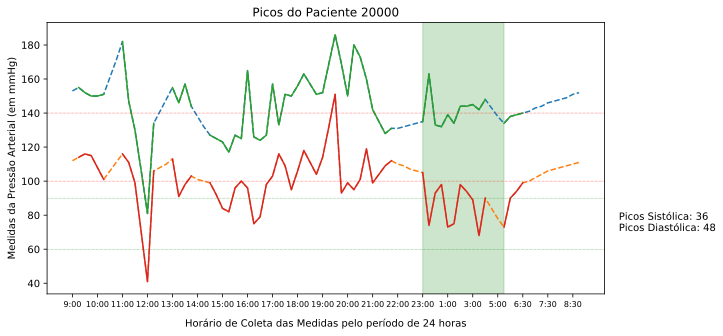

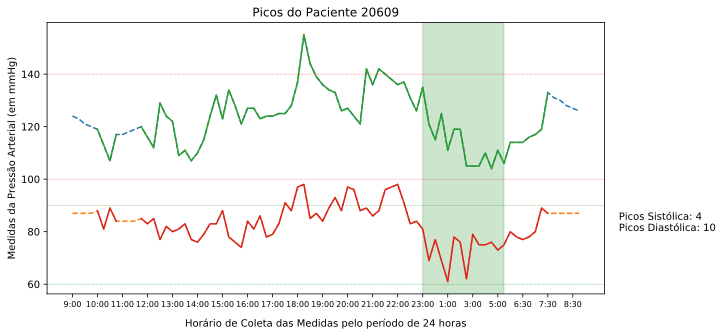

In [54]:
def legenda_picos(indice_paciente):
    picos_sist = f"Picos Sistólica: {mapas.loc[indice_paciente, 'Picos Sistolica']}"
    picos_diast = f"Picos Diastólica: {mapas.loc[indice_paciente, 'Picos Diastolica']}"
    return f"{picos_sist}\n{picos_diast}"

def estatisticas_contagem_de_picos(ids):
    plota_varios_pacientes(plt, ids, legenda_extra=legenda_picos, title="Picos do Paciente {id}",
                           nome_extra='contagem_de_picos', diretorio_de_graficos=DIR_ESTATISTICAS / "picos_pressao")
    
estatisticas_contagem_de_picos([20000, 20609])

In [55]:
mapas.loc[4,'Media Sistolica em 24h']

113.72

In [56]:
mapas[mapas.loc[:,'numero_identificacao'] == 1531]

numero_identificacao data_nascimento genero  idade  peso altura  \
1414                  1531      1964-04-09      M   54.0  82.0    166   

               data_exame  sist 9:00  sist 9:15  sist 9:30  ...  \
1414  2018-10-15 15:12:36      122.0      115.0      116.0  ...   

      Mediana Sistolica em 24h  Mediana Diastolica em 24h  \
1414                     118.0                       80.0   

      AUC Sistolica em 24h  AUC Diastolica em 24h  AUC PP Daytime  \
1414                9657.0                 6482.5          2664.5   

      AUC PP Nighttime  DP Sistolica em 24h  DP Diastolica em 24h  \
1414             481.0                 5.54                   6.7   

      Picos Sistolica  Picos Diastolica  
1414                0                 4  

[1 rows x 208 columns]

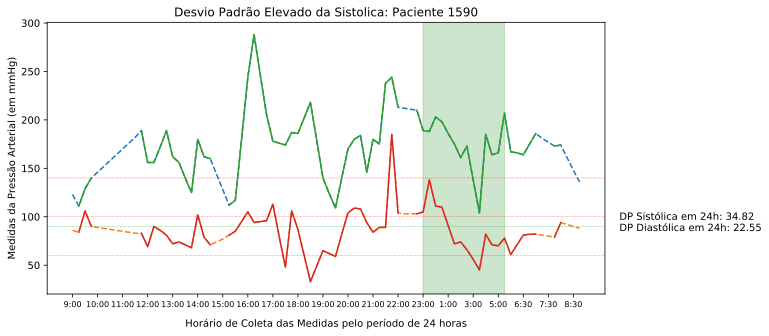

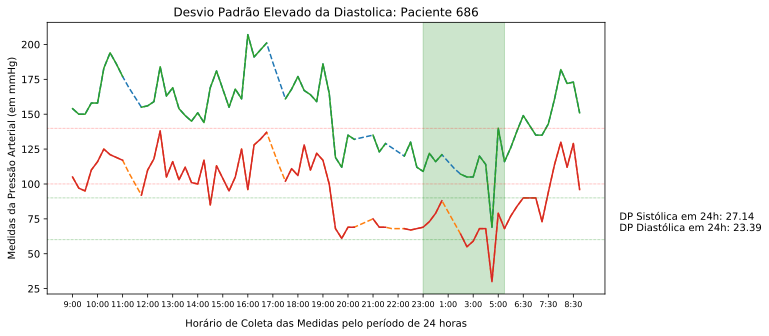

In [57]:
# Plota o gráfico dos pacientes com maiores e menores valores de Desvio Padrão da Sistólica e da Diastólica
#      DP Sist >= 30 ou DP Diast >=20

def plota_maiores_desvio_padrao(tipo='Sistolica', max_pacientes=10):
    nome_extra = f'maior_DP_{tipo}'
    titulo = f'Desvio Padrão Elevado da {tipo}: Paciente {{id}}'
    if tipo == 'Sistolica':
        limiar_DP = 30
    else: 
        limiar_DP = 20  
    pacientes = mapas[mapas[f'DP {tipo} em 24h'] >= limiar_DP]
    #  print(pacientes)
    ids = pacientes.numero_identificacao[: max_pacientes]
    # print (ids, type(ids))
    def funcao_legenda(indice_paciente):
        return legenda_com_estatisticas(indice_paciente, ['DP Sistolica em 24h', 'DP Diastolica em 24h'])
    plota_varios_pacientes(plt, ids, legenda_extra=funcao_legenda, title=titulo, nome_extra=nome_extra,
                          diretorio_de_graficos=DIR_ESTATISTICAS)


plota_maiores_desvio_padrao('Sistolica', 1)
plota_maiores_desvio_padrao('Diastolica', 1)
#
##############################################################################################################
####################################################################################################################
#        plt.savefig('D:\Projeto_PA\\estatisticas\\maior_DP_diastolica_'+str(mapas.loc[i,'numero_identificacao'])+'.svg',format="svg")


In [58]:
#mapas["numero_identificacao" == 4]
indice = mapas.loc[mapas["numero_identificacao"] == 100, :].index[0]
sist.iloc[indice, :]

sist 9:00       NaN
sist 9:15       NaN
sist 9:30       NaN
sist 9:45       NaN
sist 10:00      NaN
              ...  
sist 7:45     150.0
sist 8:00     170.0
sist 8:15     190.0
sist 8:30     259.0
sist 8:45     145.0
Name: 89, Length: 82, dtype: float64

In [59]:

eval(mapas["whitecoat"].values[0], {'nan': math.nan})[0][0]
x = ["a", "b"]
x.index("b")

1

In [60]:
datetime.strptime(mapas.loc[0, "data_exame"], "%Y-%m-%d %H:%M:%S")

datetime.datetime(2018, 9, 10, 12, 25, 23)

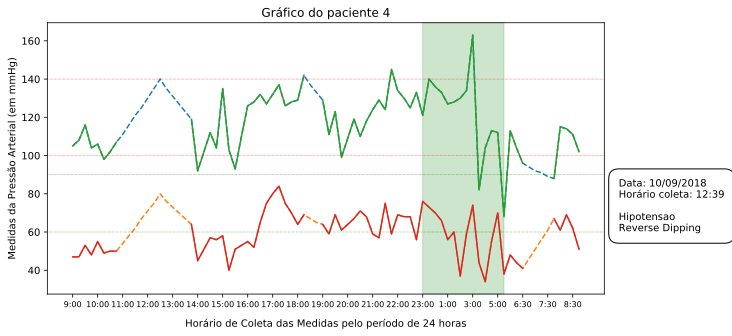

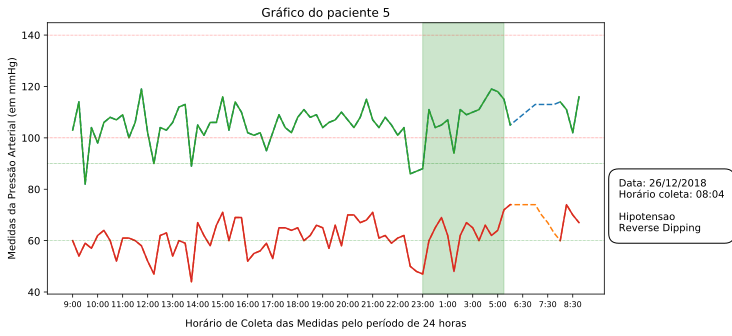

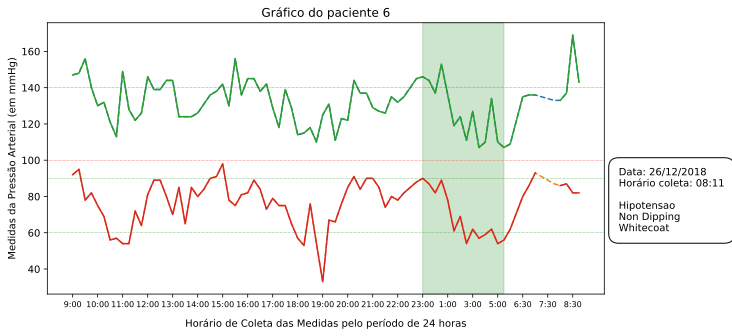

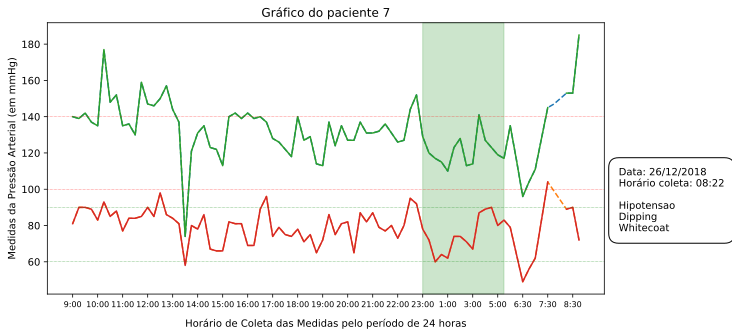

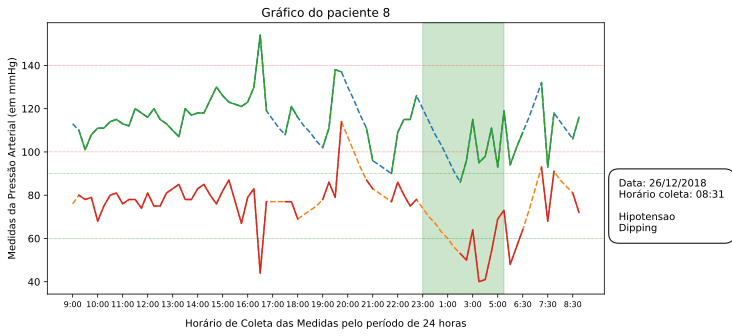

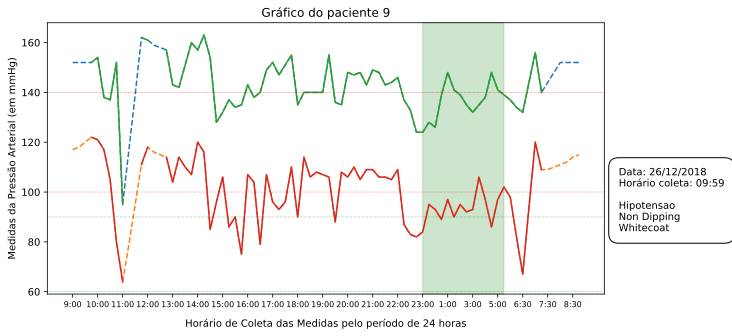

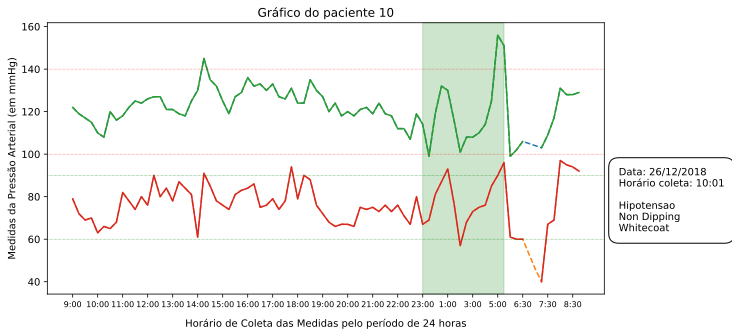

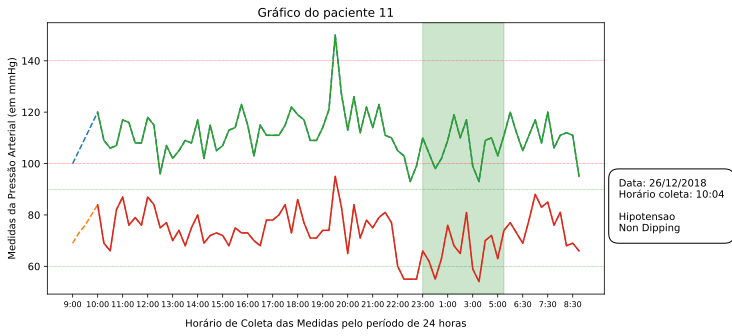

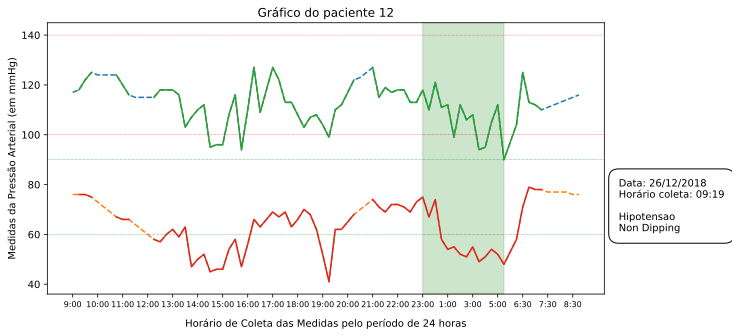

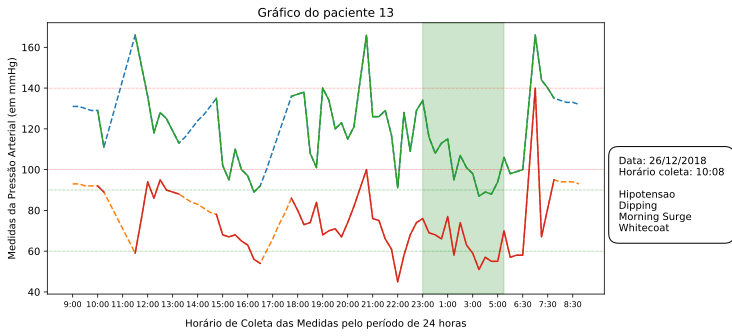

D:\Projeto_PA\Projeto_PA_validado\padrao_doenca


In [62]:
# Plota gráfico por doença com legenda das doenças diagnosticadas


def insere_horario_whitecoat(diagnosticos_positivos, paciente_escolhido):
    """Altera lista dos diagnósticos, inserindo o horário do exame no diagnostico "Whitecoat" se ele estiver presente
    """
    if not "Whitecoat" in diagnosticos_positivos and not "Masked" in diagnosticos_positivos:
        return
    # cria v
    nan = math.nan
    horario_primeira_medida = eval(mapas.loc[paciente_escolhido, 'whitecoat'], {'nan': math.nan})[0][0]
    if "Whitecoat" in diagnosticos_positivos:
        diagnosticos_positivos[diagnosticos_positivos.index('Whitecoat')] = f'Whitecoat ({horario_primeira_medida})'
    else: 
        diagnosticos_positivos[diagnosticos_positivos.index('Masked')] = f'Masked (Inicio exame: {horario_primeira_medida})'
    
def legenda_diagnosticos(indice_paciente):
    """Gera legenda com as doenças diagnosticadas para cada paciente
    
    Usada como "callback" na função de plotagem unificada
    """
    horario_primeira_medida = eval(mapas.loc[indice_paciente, 'whitecoat'], {'nan': math.nan})[0][0]
    data_exame = datetime.strptime(mapas.loc[indice_paciente, "data_exame"], "%Y-%m-%d %H:%M:%S").strftime("%d/%m/%Y")
    
    data_hora = f"Data: {data_exame}\nHorário coleta: {horario_primeira_medida}\n\n"
    
    diagnosticos = mapas.iloc[indice_paciente, :].loc["Hipotensao": "Normotenso"]
    # Filtra apenas as colunas de diagnóstico com valor "True"
    # (as variáveis criadas numa comprehension (nome_doenca, estado )  ficam restritas a expressão: deixam de existir 
    # fora do colchetes)
    diagnosticos_positivos = [nome_doenca for nome_doenca, estado in diagnosticos.iteritems() if estado]
    # insere_horario_whitecoat(diagnosticos_positivos, indice_paciente)
    if not diagnosticos_positivos:
        diagnosticos_positivos = ["fora dos padrões"]
    return  data_hora + "\n".join(diagnosticos_positivos)
    

def plota_varios_pacientes_com_diagnostico(ids, doenca="", diretorio_de_graficos=DIR_GRAFICOS_SALVOS ,**kwargs):
    """Plota gráficos de 1 ou mais pacientes, colocando legenda com os diagnósticos"""
    plota_varios_pacientes(plt, ids, legenda_extra=legenda_diagnosticos, 
                           nome_extra=f"diagnosticos{'_' + doenca if doenca else ''}",
                           diretorio_de_graficos=diretorio_de_graficos, 
                           bbox={"facecolor": "none", "edgecolor": "black", "boxstyle": "round,pad=1"},
                           **kwargs)
    
    # plt.savefig(DIR_PADROES_DOENCA / graficos_salvos /f'Grafico_paciente_{ids}.svg',format="svg")    
        
def plota_doenca(doenca, max_pacientes=10):
    pacientes = mapas[mapas[doenca]]
    ids = pacientes.numero_identificacao
    # print(ids[:2], type(ids))
    plota_varios_pacientes_com_diagnostico(ids[:max_pacientes], doenca)
    print (DIR_PADROES_DOENCA)
    # plt.savefig(DIR_PADROES_DOENCA / "graficos_salvos" /f'Grafico_padrao_{doenca, ids}.svg',format="svg") 

#plota_doenca("Whitecoat", 2)
#plota_doenca("Fora Padrões")
#plota_doenca("Masked", 1)
#plota_doenca("Sistolica Isolada", 1)
#plota_doenca("Diastolica Isolada", 3)
plota_doenca("Hipotensao", 10)
#plota_doenca("Normotenso", 3)
#plota_doenca("Morning Surge", 2)
#plota_varios_pacientes_com_diagnostico([63,72,250,310])
#plota_varios_pacientes_com_diagnostico([39])



In [63]:
mapas["Dipping"]

0        False
1        False
2        False
3         True
4         True
         ...  
19556     True
19557    False
19558    False
19559    False
19560    False
Name: Dipping, Length: 19561, dtype: bool

In [64]:
#  Widgets interactives plotando gráficos de varios pacientes e por diagnostico

import ipywidgets as widgets
from IPython.display import display

def plota_grafico(paciente, diagnostico, quantidade):
    if diagnostico == "Todos":
        plota_varios_pacientes_com_diagnostico(range(paciente, paciente + quantidade))
    else:
        plota_doenca(diagnostico, quantidade)

    
diagnosticos = list(mapas.loc[0:1, "Hipotensao": "Normotenso"].columns)
diagnosticos.insert(0, "Todos")
filtro_diagnostico = widgets.Dropdown(options=diagnosticos,description='Diagnóstico:',)
filtro_paciente = widgets.IntText(description="Paciente:")
filtro_quantidade_graficos = widgets.IntSlider(min=1, max=15)

todos_os_controles = widgets.interactive(
    plota_grafico, 
    {'manual': True},
    paciente=filtro_paciente,
    diagnostico=filtro_diagnostico,
    quantidade=filtro_quantidade_graficos
)
display(todos_os_controles)
#list(mapas.iloc[0:1,:].loc["Hipotensao": "Normotenso"].copy().columns)



interactive(children=(IntText(value=0, description='Paciente:'), Dropdown(description='Diagnóstico:', options=…

In [65]:
teste  = pd.DataFrame([[0, 1,2], [0, 1, 2]], columns=["primeira", "segunda", "terceira"] )
teste.index = ["linha um", "linha dois"]
print(teste, "\n", type(teste), type(teste.iloc[0,:]), type(teste.iloc[:, 0]))
[aa for aa in teste.iloc[0,  :].iteritems()]

            primeira  segunda  terceira
linha um           0        1         2
linha dois         0        1         2 
 <class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


[('primeira', 0), ('segunda', 1), ('terceira', 2)]